# Test 6 (Simulated Annealing)

Field: 8mT along the x axis

In [421]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas
import pandas as pd
from tqdm import tqdm
import random

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import getVerticesDict, getVerticesCount, getVerticesAverage, plotColloid, getPaintedFrame

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [422]:
def getEnergy(col):
    B0 = 20*ureg.mT
    field = [0,0,1]*B0
    E = col.calculate_energy(B = field)
    return E.magnitude

def flipColloid(col, index):
    col2 = col.copy(deep = True)
    c = col2[index]
    c.colloid = -c.colloid
    c.direction = -c.direction
    col2[index] = c
    return col2

def flipColloids(col, amount):
    indices = np.random.randint(0,len(col)-1,amount)

    for index in indices:
        col = flipColloid(col,index)
    
    return col

def isaccepted(dE,T):

    if dE < 0:
        return True
    else:
        r = np.random.rand()
        if r < np.exp(-dE/T):
            return True
        else:
            return False

In [423]:
sp = ice.spins()
# Initialize some parameters
trapSep = 10*ureg.um
particleRadius = 5*ureg.um
totalTime = 180*ureg.s

L = 30*ureg.um
N = 10

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

particle = ice.particle(radius = particleRadius,
            susceptibility = 0.0576,
            diffusion = 0.125*ureg.um**2/ureg.s,
            temperature = 300*ureg.K,
            density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
            height = 4*ureg.pN*ureg.nm,
            stiffness = 1e-3*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap,
            height_spread = 0, 
            susceptibility_spread = 0.1,
            periodic = True)

        
col.randomize()
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

# Simulated Annealing

In [424]:
np.random.seed(0)

In [425]:
E0 = getEnergy(col)
col0 = col.copy()
print(E0 / 1e6)

2.106829126288463


In [426]:
def simann(colloid, niter):
    energies = np.zeros(niter)

    energies[0] = E0

    # No sé por qué debo de calcular esto primero xd
    Eold = getEnergy(colloid)

    T = 300

    for k in tqdm(range(1,niter)):
    #for k in range(1,niter):

        newcolloid = colloid.copy(deep = True)
        newcolloid = flipColloids(newcolloid,3)

        # newcolloid.randomize()

        Enew = getEnergy(newcolloid)
        dE = Enew - Eold

        # Accept or reject the change
        if isaccepted(dE,T):
            colloid = newcolloid.copy(deep = True)
            Eold = Enew
            energies[k] = Eold
        else:
            energies[k] = Eold
        
        T = 0.9*T
    
    return colloid, energies


In [427]:
col2, energies = simann(col,10000)

 67%|██████▋   | 6696/9999 [33:50<12:01,  4.58it/s]  /tmp/ipykernel_16129/3309251635.py:29: RuntimeWarning: overflow encountered in scalar divide
  if r < np.exp(-dE/T):
100%|██████████| 9999/9999 [43:58<00:00,  3.79it/s]


In [433]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

Text(0.5, 0, 'MC Steps')

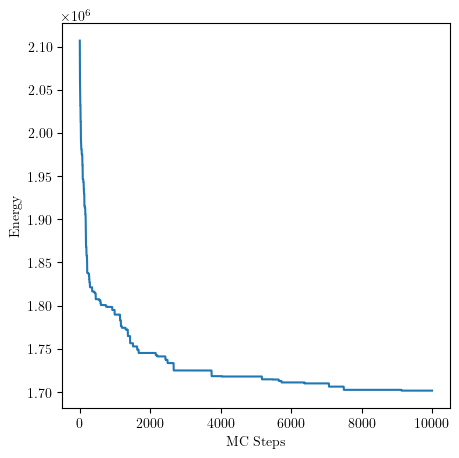

In [435]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(energies)
ax.set_ylabel("Energy")
ax.set_xlabel("MC Steps")

In [429]:
getEnergy(col2) / 1e6

1.7015333649632085

In [430]:
energies[-1] / 1e6

1.7015333649632085

100%|██████████| 200/200 [00:01<00:00, 173.66it/s]


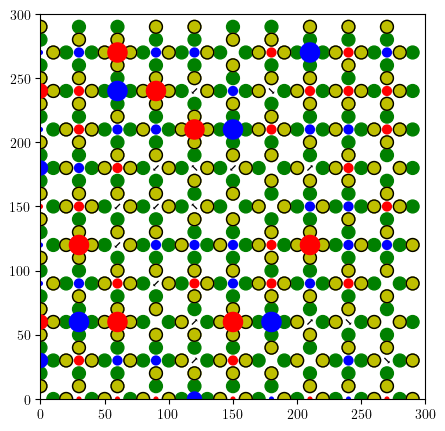

In [436]:
fig, ax = plt.subplots(figsize=(5,5))
v = ice.vertices()
v = v.colloids_to_vertices(col)
col.display(ax)
v.display()
fig.savefig("initial.png")

100%|██████████| 200/200 [00:01<00:00, 164.42it/s]


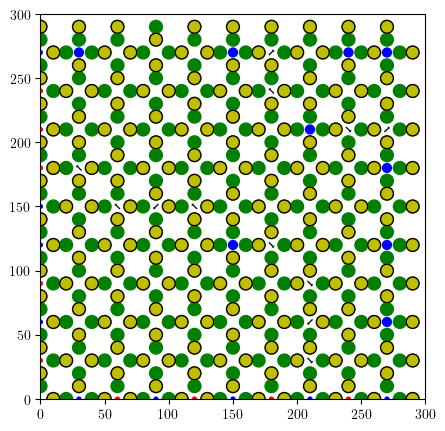

In [437]:
fig, ax = plt.subplots(figsize=(5,5))
v = ice.vertices()
v = v.colloids_to_vertices(col2)
col2.display(ax)
v.display()
fig.savefig("final.png")

# Problemas

No entiendo por qué no me regresa el estado con el que terminó...

No entiendo nada

In [401]:
sp = ice.spins()
# Initialize some parameters
trapSep = 10*ureg.um
particleRadius = 5*ureg.um
totalTime = 180*ureg.s

L = 30*ureg.um
N = 10

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

particle = ice.particle(radius = particleRadius,
            susceptibility = 0.0576,
            diffusion = 0.125*ureg.um**2/ureg.s,
            temperature = 300*ureg.K,
            density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
            height = 4*ureg.pN*ureg.nm,
            stiffness = 1e-3*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap,
            height_spread = 0, 
            susceptibility_spread = 0.1,
            periodic = True)

        
col.randomize()
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

Creo mi coloide inicial.

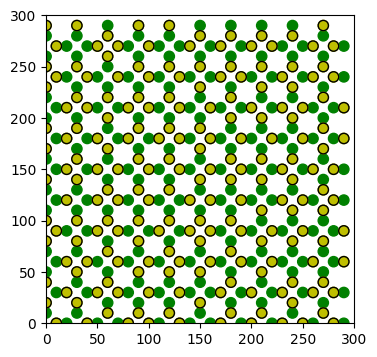

In [402]:
fig, ax = plt.subplots(figsize=(4,4))
col.display(ax)
fig.savefig("col0.png")

In [403]:
col2 = flipColloid(col,10)

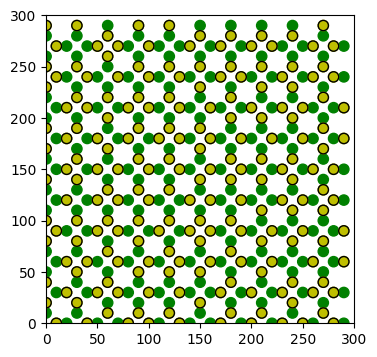

In [404]:
fig, ax = plt.subplots(figsize=(4,4))
col.display(ax)
fig.savefig("col1.png")

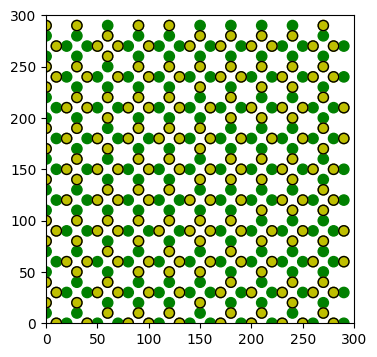

In [405]:
fig, ax = plt.subplots(figsize=(4,4))
col2.display(ax)
fig.savefig("col2.png")
